# 4-1. 프로젝트: 뉴스기사 요약해보기

In [77]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from bs4 import BeautifulSoup

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import numpy as np
import summa
import pandas as pd
import urllib.request
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 1. 데이터 수집하기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


### Step 2. 데이터 전처리하기 (추상적 요약)

##### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


##### 텍스트 정규화와 불용어 제거

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
clean_text = []

with tf.device('/gpu:0'):
    for i in data['text']:
        clean_text.append(preprocess_sentence(i))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [10]:
clean_summary = []

for i in data['headlines']:
    clean_summary.append(preprocess_sentence(i, False))

print("headlines 전처리 후 결과: ", clean_summary[:5])

c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\ipykernel_launcher.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  after removing the cwd from sys.path.


headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [30]:
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [31]:
data.isnull().sum()

headlines    0
text         0
Text         0
Summary      0
dtype: int64

In [32]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


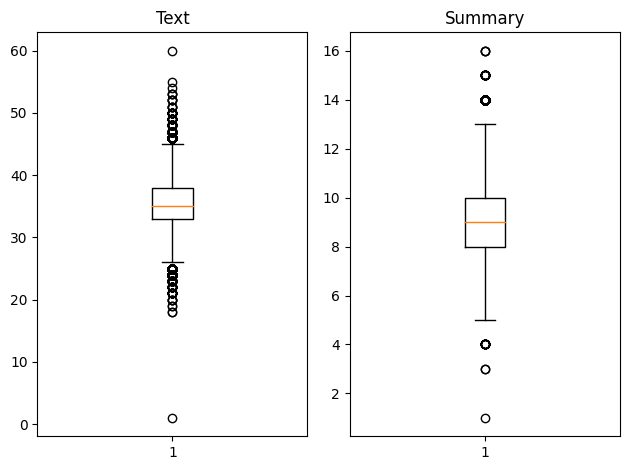

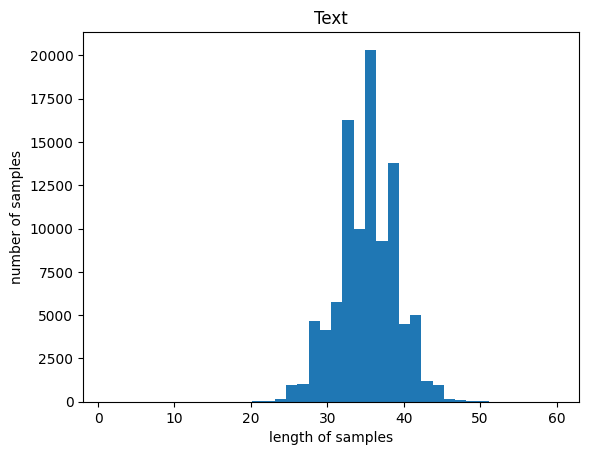

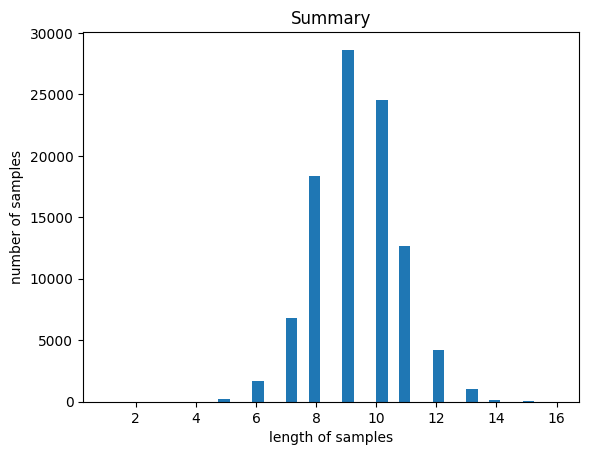

In [33]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [57]:
text_min_len = 30
text_max_len = 40
headlines_min_len = 6
headlines_max_len = 12

In [53]:
def below_threshold_len(min_len, max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) >= min_len and len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이상, %s 이하인 샘플의 비율: %s'%(min_len, max_len, (cnt / len(nested_list))))

In [58]:
below_threshold_len(text_min_len, text_max_len, data['text'])
below_threshold_len(headlines_min_len, headlines_max_len, data['headlines'])

전체 샘플 중 길이가 30 이상, 40 이하인 샘플의 비율: 0.8539955266368442
전체 샘플 중 길이가 6 이상, 12 이하인 샘플의 비율: 0.9855734038226922


In [59]:
data = data[
data['text'].apply(lambda x: len(x.split()) >= text_min_len) &
data['text'].apply(lambda x: len(x.split()) <= text_max_len) &
data['headlines'].apply(lambda x: len(x.split()) >= headlines_min_len) &
data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)
]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 82838


##### 데이터셋 분리

In [60]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\user\miniconda3\envs\aifenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [61]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [62]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[28898 52830 33822 ... 46181 29875 10280]


In [63]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [64]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16567


In [65]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 66271
훈련 레이블의 개수 : 66271
테스트 데이터의 개수 : 16567
테스트 레이블의 개수 : 16567


##### 정수 인코딩

In [68]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [69]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64126
등장 빈도가 6번 이하인 희귀 단어의 수: 43681
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20445
단어 집합에서 희귀 단어의 비율: 68.11745625799207
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.826807313800093


In [70]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [71]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[361, 3871, 4384, 1243, 4849, 414, 12969, 3747, 131, 1170, 12970, 12971, 90, 1731, 240, 11, 1173, 202, 54, 4849, 1775, 248, 376, 3540, 15217, 7659, 275, 2899, 521, 12969, 376, 301, 329, 4620, 940], [3769, 3, 13, 4067, 1518, 5626, 1826, 1601, 53, 2, 581, 1518, 180, 14, 1939, 1482, 292, 855, 562, 1030, 203, 73, 466, 2521, 2357, 16853, 3872, 814, 1826, 4178, 11714, 156, 368, 331], [29, 316, 102, 1255, 1105, 590, 1524, 126, 389, 112, 316, 1079, 110, 882, 110, 167, 376, 2474, 1881, 882, 11715, 1171, 1495, 959, 2032, 73, 5226, 6078, 1043, 2474, 6, 2032, 572, 126, 389]]


In [72]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [73]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28010
등장 빈도가 5번 이하인 희귀 단어의 수: 18476
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9534
단어 집합에서 희귀 단어의 비율: 65.96215637272402
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.2230274048188345


In [74]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2996, 3637, 773, 4, 92, 2151, 871, 2064, 6939], [1, 150, 1200, 3, 4840, 1035, 8673, 4, 8], [1, 1230, 670, 3, 12, 3242, 44, 387, 130, 13, 186], [1, 15, 67, 46, 215, 1835, 856, 10, 240, 454, 11, 948], [1, 343, 633, 6, 1935, 594, 1258, 6, 24, 3, 47]]
target
decoder  [[2996, 3637, 773, 4, 92, 2151, 871, 2064, 6939, 2], [150, 1200, 3, 4840, 1035, 8673, 4, 8, 2], [1230, 670, 3, 12, 3242, 44, 387, 130, 13, 186, 2], [15, 67, 46, 215, 1835, 856, 10, 240, 454, 11, 948, 2], [343, 633, 6, 1935, 594, 1258, 6, 24, 3, 47, 2]]


In [75]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 66271
훈련 레이블의 개수 : 66271
테스트 데이터의 개수 : 16567
테스트 레이블의 개수 : 16567


In [78]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### Step 3. 어텐션 매커니즘 사용하기 (추상적 요약)

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [80]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(enc_emb)

In [81]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [82]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1152000     ['input_2[0][0]']                
                                                                                              

In [83]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2560000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 128)    1152000     ['input_2[0][0]']                
                                                                                            

In [84]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

with tf.device('/gpu:0'):
    history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
            validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
            batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
259/259 [==============================] - 35s 69ms/step - loss: 5.6227 - val_loss: 5.2472
Epoch 2/50
259/259 [==============================] - 22s 85ms/step - loss: 5.1505 - val_loss: 4.9423
Epoch 3/50
259/259 [==============================] - 24s 92ms/step - loss: 4.8056 - val_loss: 4.6152
Epoch 4/50
259/259 [==============================] - 24s 92ms/step - loss: 4.4990 - val_loss: 4.3840
Epoch 5/50
259/259 [==============================] - 22s 87ms/step - loss: 4.2653 - val_loss: 4.2332
Epoch 6/50
259/259 [==============================] - 23s 90ms/step - loss: 4.0811 - val_loss: 4.1154
Epoch 7/50
259/259 [==============================] - 24s 92ms/step - loss: 3.9238 - val_loss: 4.0202
Epoch 8/50
259/259 [==============================] - 24s 91ms/step - loss: 3.7860 - val_loss: 3.9400
Epoch 9/50
259/259 [==============================] - 23s 90ms/step - loss: 3.6637 - val_loss: 3.8852
Epoch 10/50
259/259 [==============================] - 23s 89ms/step - loss: 3.552

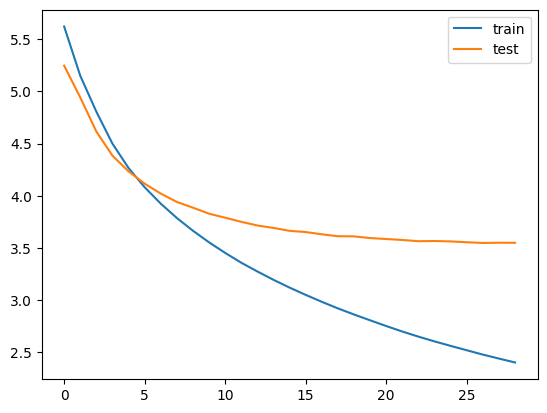

In [85]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [86]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [87]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [88]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0 & i!=tar_word_to_index['sostoken'] & i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i]+' '
    return temp

In [91]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : nasa offering overall cash prizes winners computing challenge speed supercomputer codes aerospace software participants would required download original code nasa website speed processing times without decrease accuracy however challenge open us citizens 
실제 요약 : sostoken offering to speed its supercomputer code 
1/1 [==============================] - 0s 51ms/step
예측 요약 :  nasa to use of chip to avoid


원문 : income tax department planned target lakh people suspected filed returns last year reports said added focus deposited lakh demonetised notes file returns reports said notably government added nearly one crore new taxpayers last fiscal 
실제 요약 : sostoken to target for returns 
1/1 [==============================] - 0s 35ms/step
예측 요약 :  dept asks banks to return to return to


원문 : government friday issued thunderstorm warnings west bengal odisha bihar uttar pradesh people killed dust storms met department officials predicted another dust storm parts rajasthan uttar pradesh next

### Step 5. Summa을 이용해서 추출적 요약해보기

In [ ]:
from summa.summarizer import summarize

In [94]:
with open('Israel and Hezbollah close to Lebanon ceasefire deal.txt', 'r') as f:
    text = f.read()

In [95]:
print(text[:1500])

Israel and Lebanon appear to be close to a ceasefire deal, with the Israeli cabinet set to meet on Tuesday to discuss it, Israeli and US officials say.

A 60-day truce is being proposed to end fighting between Israel and the Iranian-backed Lebanese militia Hezbollah.

It is said to include the withdrawal of Israeli forces from southern Lebanon and an end to the Hezbollah presence in the area.

"We believe we've reached this point where we're close," US National Security Council spokesman John Kirby said. But he added, "We're not there yet."

The US and France - a long-term ally of Lebanon - have been involved in the search for a ceasefire.

It is often said that the darkest hour is before the dawn. There has been an intensification in the exchange of fire between Israel and Hezbollah, just as the two sides haggle over the final details of the deal.

Sunday saw around 250 projectiles fired into Israel from Lebanon, with most intercepted, while the Israeli Air Force has continued to carr

In [97]:
print('headlines:')
print(summarize(text, ratio=0.005))

headlines:



In [98]:
print('headlines:')
print(summarize(text, ratio=0.005, split=True))

headlines:
[]


In [99]:
print('headlines:')
print(summarize(text, words=50))

headlines:
Israel and Lebanon appear to be close to a ceasefire deal, with the Israeli cabinet set to meet on Tuesday to discuss it, Israeli and US officials say.
It is said to include the withdrawal of Israeli forces from southern Lebanon and an end to the Hezbollah presence in the area.


In [100]:
model.save('lstm.h5')

In [101]:
decoder_model.save('decoder.h5')

In [102]:
encoder_model.save('encoder.h5')